In [5]:
import os, sys, pathlib, pandas as pd

# Ensure we're at repo root and can import src
if pathlib.Path.cwd().name == "notebooks":
    os.chdir("..")
ROOT = pathlib.Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.config import INTERIM_DIR

# Load latest parquet sample
p = max(pathlib.Path(INTERIM_DIR).glob("train_sample_*.parquet"), key=lambda x: x.stat().st_mtime)
df = pd.read_parquet(p, engine="pyarrow")
df["dt"] = pd.to_datetime(df["dt"])
print("Loaded:", df.shape, "from", p)

# Build daily total sales series (no df_model needed)
daily = df.groupby("dt")["sale_amount"].sum().sort_index()
daily.head()

Loaded: (200000, 19) from data/interim/train_sample_200000.parquet


dt
2024-03-28    1623.780
2024-03-29    1552.430
2024-03-30    2099.570
2024-03-31    2296.700
2024-04-01    1587.539
Name: sale_amount, dtype: float64

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def evaluate_baseline(y_true, y_pred, name="baseline"):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    print(f"{name} → RMSE: {rmse:.4f}, MAPE: {mape:.2%}")
    return rmse, mape

In [7]:
# Naive baseline on daily totals
y_true = daily[1:]                 # drop first day
y_pred = daily.shift(1)[1:]        # yesterday's value
naive_rmse, naive_mape = evaluate_baseline(y_true, y_pred, "Naive")

Naive → RMSE: 404.0810, MAPE: 14.17%


In [8]:
y_true = daily[7:]                                  # need 7 days history
y_pred = daily.rolling(7).mean().shift(1)[7:]       # last 7 days average, predicted for next day
ma7_rmse, ma7_mape = evaluate_baseline(y_true, y_pred, "7-Day MA")

7-Day MA → RMSE: 347.4506, MAPE: 11.92%


In [9]:
y_true = daily[30:]
y_pred = daily.rolling(30).mean().shift(1)[30:]
ma30_rmse, ma30_mape = evaluate_baseline(y_true, y_pred, "30-Day MA")

30-Day MA → RMSE: 376.0932, MAPE: 10.99%


In [10]:
import pandas as pd
baseline_results = pd.DataFrame(
    {"Model": ["Naive", "7-Day MA", "30-Day MA"],
     "RMSE": [naive_rmse, ma7_rmse, ma30_rmse],
     "MAPE": [naive_mape, ma7_mape, ma30_mape]}
)
baseline_results

,Model,RMSE,MAPE
0,Naive,404.080975,0.141724
1,7-Day MA,347.450604,0.119225
2,30-Day MA,376.093226,0.109913


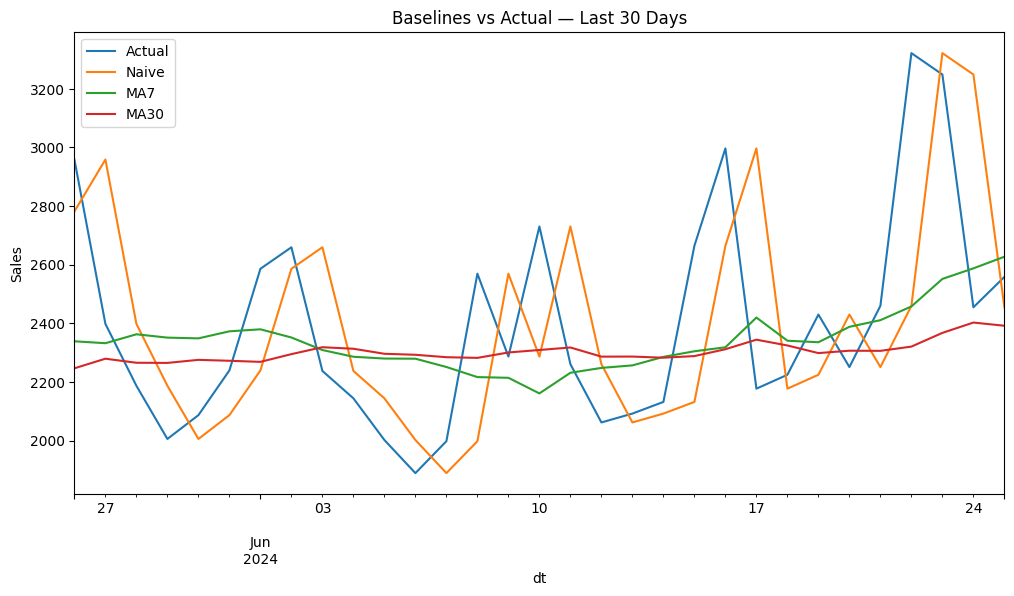

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# last 30 days of the daily total series
last_30 = daily[daily.index >= daily.index.max() - pd.Timedelta(days=30)].copy()

naive_ = daily.shift(1).reindex(last_30.index).rename("Naive")
ma7_   = daily.rolling(7).mean().shift(1).reindex(last_30.index).rename("MA7")
ma30_  = daily.rolling(30).mean().shift(1).reindex(last_30.index).rename("MA30")
actual = last_30.rename("Actual")

plot_df = pd.concat([actual, naive_, ma7_, ma30_], axis=1)

ax = plot_df.plot(figsize=(12,6), title="Baselines vs Actual — Last 30 Days")
ax.set_ylabel("Sales")
plt.show()